# Dog Heart Vertebral Heart Size Point Detection

# 1. Build an object detection model using pytorch

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torchvision.models import EfficientNet_B7_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from scipy.io import loadmat
import csv

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
class DogHeartLandmarkDataset(Dataset):
    def __init__(self, root_dir: str, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_dir = os.path.join(root_dir, "Images")
        self.label_dir = os.path.join(root_dir, "Labels")

        self.image_files = sorted([f for f in os.listdir(self.image_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        self.label_files = sorted([f for f in os.listdir(self.label_dir) if f.endswith('.mat')])
        self._validate_pairs()

    def _validate_pairs(self):
        assert len(self.image_files) == len(self.label_files)
        for img, lbl in zip(self.image_files, self.label_files):
            assert os.path.splitext(img)[0] == os.path.splitext(lbl)[0]

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        original_w, original_h = image.size

        if self.transform:
            image = self.transform(image)
            _, new_h, new_w = image.shape

        label_path = os.path.join(self.label_dir, self.label_files[idx])
        mat = loadmat(label_path)
        points = torch.as_tensor(mat['six_points'].astype(np.float32))
        vhs = torch.as_tensor(mat['VHS'].astype(np.float32))

        if self.transform:
            points[:, 0] *= (new_w / original_w)
            points[:, 1] *= (new_h / original_h)
            points = points.reshape(-1) / new_h

        return image, points, vhs

    def __len__(self):
        return len(self.image_files)

class DogHeartTestDataset(Dataset):
    def __init__(self, root_dir: str, transform=None):
        self.root_dir = os.path.join(root_dir, "Images")
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(self.root_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, os.path.splitext(self.image_files[idx])[0]

    def __len__(self):
        return len(self.image_files)

def create_transforms(image_size=300, augment=False):
    transforms = [
        T.ToTensor(),
        T.Resize((image_size, image_size)),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
    if augment:
        transforms.insert(1, T.RandomHorizontalFlip(p=0.5))
    return T.Compose(transforms)

INPUT_PATH = '/kaggle/input/dog-heart-vhs/Dog_Heart_VHS'

train_transform = create_transforms(augment=True)
val_transform = create_transforms()
test_transform = create_transforms()

train_dataset = DogHeartLandmarkDataset(os.path.join(INPUT_PATH, 'Train'), train_transform)
val_dataset = DogHeartLandmarkDataset(os.path.join(INPUT_PATH, 'Valid'), val_transform)
test_dataset = DogHeartTestDataset(os.path.join(INPUT_PATH, 'Test_Images'), test_transform)

BATCH_SIZE = 8
data_loaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2),
    'test': DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
}

train_images = len(train_dataset)
val_images = len(val_dataset)
test_images = len(test_dataset)

train_batches = len(data_loaders['train'])
val_batches = len(data_loaders['val'])
test_batches = len(data_loaders['test'])

print("\nDataset Statistics:")
print(f"Train Images: {train_images}, Batches: {train_batches}")
print(f"Validation Images: {val_images}, Batches: {val_batches}")
print(f"Test Images: {test_images}, Batches: {test_batches}")


Dataset Statistics:
Train Images: 1400, Batches: 175
Validation Images: 200, Batches: 25
Test Images: 400, Batches: 50


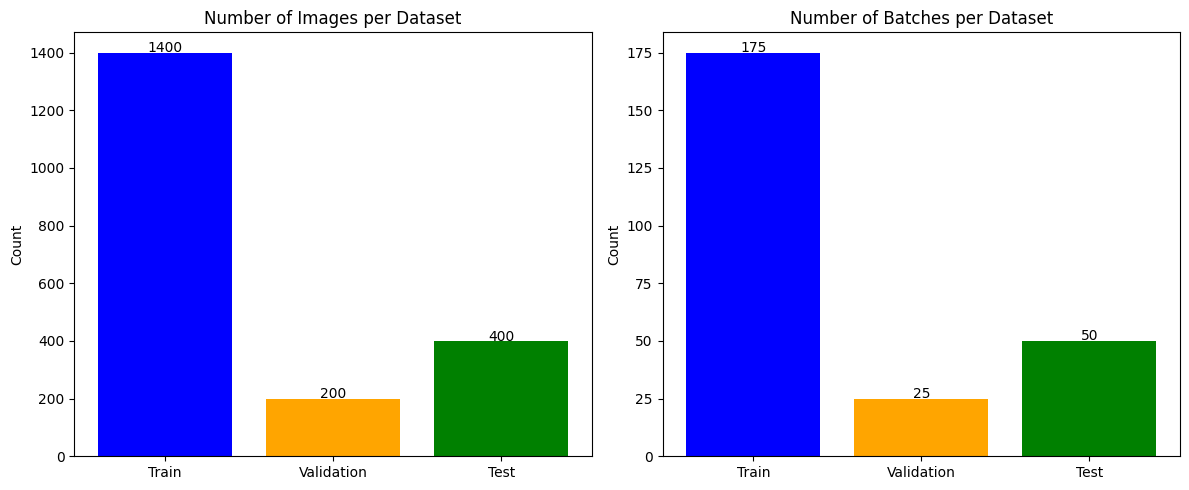

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

categories = ['Train', 'Validation', 'Test']
image_counts = [train_images, val_images, test_images]
ax1.bar(categories, image_counts, color=['blue', 'orange', 'green'])
ax1.set_title('Number of Images per Dataset')
ax1.set_ylabel('Count')
for i, v in enumerate(image_counts):
    ax1.text(i, v + 0.5, str(v), ha='center')

batch_counts = [train_batches, val_batches, test_batches]
ax2.bar(categories, batch_counts, color=['blue', 'orange', 'green'])
ax2.set_title('Number of Batches per Dataset')
ax2.set_ylabel('Count')
for i, v in enumerate(batch_counts):
    ax2.text(i, v + 0.2, str(v), ha='center')

plt.tight_layout()
plt.show()

# 2. Train your model using [Dog VHS Dataset](https://yuad-my.sharepoint.com/:f:/g/personal/youshan_zhang_yu_edu/ErguFJBE4y9KqzEdWWNlXzMBkTbsBaNX9l856SyvQauwJg?e=L3JOuN)

In [ ]:
class DogHeartLandmarkModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.efficientnet_b7(weights=EfficientNet_B7_Weights.IMAGENET1K_V1)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(in_features, 1024),
            nn.ReLU(),
            nn.Linear(1024, 6*2)
        )

    def forward(self, x):
        return self.backbone(x)

def dog_wing_loss(pred, target, w=10.0, epsilon=2.0):
    return nn.MSELoss()(pred, target)

def train_dog_model():
    model = DogHeartLandmarkModel().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0007, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)
    scaler = GradScaler()

    best_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(100):
        model.train()
        train_loss = 0.0

        for images, landmarks, _ in tqdm(data_loaders['train'], desc=f"Epoch {epoch+1}/100"):
            images, landmarks = images.to(device), landmarks.to(device)

            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                smooth_l1 = nn.MSELoss()(outputs, landmarks)
                wing = dog_wing_loss(outputs, landmarks)
                loss = 0.7 * smooth_l1 + 0.3 * wing

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, landmarks, _ in data_loaders['val']:
                images, landmarks = images.to(device), landmarks.to(device)
                outputs = model(images)
                val_loss += nn.MSELoss()(outputs, landmarks).item()

        train_loss /= len(data_loaders['train'])
        val_loss /= len(data_loaders['val'])
        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"\nEpoch {epoch+1} Results:")
        print(f"Train Loss: {train_loss:.6f}")
        print(f"Val Loss: {val_loss:.6f}")

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_dog_model.pth')
            print(f"Saved new best model (Val Loss: {best_loss:.6f})")

    print(f"\nTraining complete! Best Val Loss: {best_loss:.6f}")

    return train_losses, val_losses

train_losses, val_losses = train_dog_model()

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [01:24<00:00, 3.15MB/s] 
<ipython-input-5-92ea974c103b>:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/100:   0%|          | 0/175 [00:00<?, ?it/s]<ipython-input-5-92ea974c103b>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/100: 100%|██████████| 175/175 [00:55<00:00,  3.17it/s]



Epoch 1 Results:
Train Loss: 0.031194
Val Loss: 0.013558
Saved new best model (Val Loss: 0.013558)


Epoch 2/100: 100%|██████████| 175/175 [00:50<00:00,  3.48it/s]



Epoch 2 Results:
Train Loss: 0.007392
Val Loss: 0.003071
Saved new best model (Val Loss: 0.003071)


Epoch 3/100: 100%|██████████| 175/175 [00:52<00:00,  3.36it/s]



Epoch 3 Results:
Train Loss: 0.002996
Val Loss: 0.001698
Saved new best model (Val Loss: 0.001698)


Epoch 4/100: 100%|██████████| 175/175 [00:53<00:00,  3.30it/s]



Epoch 4 Results:
Train Loss: 0.002296
Val Loss: 0.004387


Epoch 5/100: 100%|██████████| 175/175 [00:52<00:00,  3.31it/s]



Epoch 5 Results:
Train Loss: 0.001896
Val Loss: 0.001229
Saved new best model (Val Loss: 0.001229)


Epoch 6/100: 100%|██████████| 175/175 [00:52<00:00,  3.30it/s]



Epoch 6 Results:
Train Loss: 0.001677
Val Loss: 0.001211
Saved new best model (Val Loss: 0.001211)


Epoch 7/100: 100%|██████████| 175/175 [00:52<00:00,  3.30it/s]



Epoch 7 Results:
Train Loss: 0.001567
Val Loss: 0.004926


Epoch 8/100: 100%|██████████| 175/175 [00:52<00:00,  3.31it/s]



Epoch 8 Results:
Train Loss: 0.001348
Val Loss: 0.001106
Saved new best model (Val Loss: 0.001106)


Epoch 9/100: 100%|██████████| 175/175 [00:52<00:00,  3.31it/s]



Epoch 9 Results:
Train Loss: 0.001132
Val Loss: 0.001387


Epoch 10/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 10 Results:
Train Loss: 0.001180
Val Loss: 0.000688
Saved new best model (Val Loss: 0.000688)


Epoch 11/100: 100%|██████████| 175/175 [00:52<00:00,  3.31it/s]



Epoch 11 Results:
Train Loss: 0.001026
Val Loss: 0.000559
Saved new best model (Val Loss: 0.000559)


Epoch 12/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 12 Results:
Train Loss: 0.000869
Val Loss: 0.000355
Saved new best model (Val Loss: 0.000355)


Epoch 13/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 13 Results:
Train Loss: 0.000666
Val Loss: 0.000743


Epoch 14/100: 100%|██████████| 175/175 [00:52<00:00,  3.33it/s]



Epoch 14 Results:
Train Loss: 0.000638
Val Loss: 0.000368


Epoch 15/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 15 Results:
Train Loss: 0.000612
Val Loss: 0.000339
Saved new best model (Val Loss: 0.000339)


Epoch 16/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 16 Results:
Train Loss: 0.000584
Val Loss: 0.000380


Epoch 17/100: 100%|██████████| 175/175 [00:52<00:00,  3.34it/s]



Epoch 17 Results:
Train Loss: 0.000566
Val Loss: 0.000390


Epoch 18/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 18 Results:
Train Loss: 0.000547
Val Loss: 0.000334
Saved new best model (Val Loss: 0.000334)


Epoch 19/100: 100%|██████████| 175/175 [00:52<00:00,  3.33it/s]



Epoch 19 Results:
Train Loss: 0.000489
Val Loss: 0.000588


Epoch 20/100: 100%|██████████| 175/175 [00:52<00:00,  3.34it/s]



Epoch 20 Results:
Train Loss: 0.000518
Val Loss: 0.000330
Saved new best model (Val Loss: 0.000330)


Epoch 21/100: 100%|██████████| 175/175 [00:52<00:00,  3.33it/s]



Epoch 21 Results:
Train Loss: 0.000472
Val Loss: 0.000461


Epoch 22/100: 100%|██████████| 175/175 [00:52<00:00,  3.33it/s]



Epoch 22 Results:
Train Loss: 0.000475
Val Loss: 0.000298
Saved new best model (Val Loss: 0.000298)


Epoch 23/100: 100%|██████████| 175/175 [00:52<00:00,  3.34it/s]



Epoch 23 Results:
Train Loss: 0.000443
Val Loss: 0.000354


Epoch 24/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 24 Results:
Train Loss: 0.000365
Val Loss: 0.000282
Saved new best model (Val Loss: 0.000282)


Epoch 25/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 25 Results:
Train Loss: 0.000355
Val Loss: 0.000296


Epoch 26/100: 100%|██████████| 175/175 [00:52<00:00,  3.33it/s]



Epoch 26 Results:
Train Loss: 0.000341
Val Loss: 0.000348


Epoch 27/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 27 Results:
Train Loss: 0.000351
Val Loss: 0.000273
Saved new best model (Val Loss: 0.000273)


Epoch 28/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 28 Results:
Train Loss: 0.000343
Val Loss: 0.000323


Epoch 29/100: 100%|██████████| 175/175 [00:52<00:00,  3.33it/s]



Epoch 29 Results:
Train Loss: 0.000324
Val Loss: 0.000381


Epoch 30/100: 100%|██████████| 175/175 [00:52<00:00,  3.31it/s]



Epoch 30 Results:
Train Loss: 0.000323
Val Loss: 0.000349


Epoch 31/100: 100%|██████████| 175/175 [00:52<00:00,  3.34it/s]



Epoch 31 Results:
Train Loss: 0.000314
Val Loss: 0.000267
Saved new best model (Val Loss: 0.000267)


Epoch 32/100: 100%|██████████| 175/175 [00:52<00:00,  3.34it/s]



Epoch 32 Results:
Train Loss: 0.000311
Val Loss: 0.000274


Epoch 33/100: 100%|██████████| 175/175 [00:52<00:00,  3.33it/s]



Epoch 33 Results:
Train Loss: 0.000307
Val Loss: 0.000278


Epoch 34/100: 100%|██████████| 175/175 [00:52<00:00,  3.33it/s]



Epoch 34 Results:
Train Loss: 0.000282
Val Loss: 0.000349


Epoch 35/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 35 Results:
Train Loss: 0.000258
Val Loss: 0.000236
Saved new best model (Val Loss: 0.000236)


Epoch 36/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 36 Results:
Train Loss: 0.000250
Val Loss: 0.000241


Epoch 37/100: 100%|██████████| 175/175 [00:52<00:00,  3.34it/s]



Epoch 37 Results:
Train Loss: 0.000239
Val Loss: 0.000261


Epoch 38/100: 100%|██████████| 175/175 [00:52<00:00,  3.33it/s]



Epoch 38 Results:
Train Loss: 0.000227
Val Loss: 0.000247


Epoch 39/100: 100%|██████████| 175/175 [00:52<00:00,  3.33it/s]



Epoch 39 Results:
Train Loss: 0.000232
Val Loss: 0.000249


Epoch 40/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 40 Results:
Train Loss: 0.000191
Val Loss: 0.000218
Saved new best model (Val Loss: 0.000218)


Epoch 41/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 41 Results:
Train Loss: 0.000179
Val Loss: 0.000222


Epoch 42/100: 100%|██████████| 175/175 [00:52<00:00,  3.31it/s]



Epoch 42 Results:
Train Loss: 0.000182
Val Loss: 0.000224


Epoch 43/100: 100%|██████████| 175/175 [00:52<00:00,  3.33it/s]



Epoch 43 Results:
Train Loss: 0.000178
Val Loss: 0.000226


Epoch 44/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 44 Results:
Train Loss: 0.000175
Val Loss: 0.000217
Saved new best model (Val Loss: 0.000217)


Epoch 45/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 45 Results:
Train Loss: 0.000179
Val Loss: 0.000223


Epoch 46/100: 100%|██████████| 175/175 [00:52<00:00,  3.33it/s]



Epoch 46 Results:
Train Loss: 0.000178
Val Loss: 0.000216
Saved new best model (Val Loss: 0.000216)


Epoch 47/100: 100%|██████████| 175/175 [00:52<00:00,  3.33it/s]



Epoch 47 Results:
Train Loss: 0.000169
Val Loss: 0.000220


Epoch 48/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 48 Results:
Train Loss: 0.000170
Val Loss: 0.000214
Saved new best model (Val Loss: 0.000214)


Epoch 49/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 49 Results:
Train Loss: 0.000171
Val Loss: 0.000218


Epoch 50/100: 100%|██████████| 175/175 [00:52<00:00,  3.34it/s]



Epoch 50 Results:
Train Loss: 0.000171
Val Loss: 0.000216


Epoch 51/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 51 Results:
Train Loss: 0.000172
Val Loss: 0.000229


Epoch 52/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 52 Results:
Train Loss: 0.000172
Val Loss: 0.000221


Epoch 53/100: 100%|██████████| 175/175 [00:52<00:00,  3.33it/s]



Epoch 53 Results:
Train Loss: 0.000168
Val Loss: 0.000218


Epoch 54/100: 100%|██████████| 175/175 [00:52<00:00,  3.31it/s]



Epoch 54 Results:
Train Loss: 0.000164
Val Loss: 0.000217


Epoch 55/100: 100%|██████████| 175/175 [00:53<00:00,  3.29it/s]



Epoch 55 Results:
Train Loss: 0.000166
Val Loss: 0.000218


Epoch 56/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 56 Results:
Train Loss: 0.000166
Val Loss: 0.000216


Epoch 57/100: 100%|██████████| 175/175 [00:53<00:00,  3.30it/s]



Epoch 57 Results:
Train Loss: 0.000168
Val Loss: 0.000218


Epoch 58/100: 100%|██████████| 175/175 [00:53<00:00,  3.29it/s]



Epoch 58 Results:
Train Loss: 0.000166
Val Loss: 0.000217


Epoch 59/100: 100%|██████████| 175/175 [00:53<00:00,  3.29it/s]



Epoch 59 Results:
Train Loss: 0.000164
Val Loss: 0.000216


Epoch 60/100: 100%|██████████| 175/175 [00:53<00:00,  3.28it/s]



Epoch 60 Results:
Train Loss: 0.000162
Val Loss: 0.000217


Epoch 61/100: 100%|██████████| 175/175 [00:53<00:00,  3.29it/s]



Epoch 61 Results:
Train Loss: 0.000162
Val Loss: 0.000216


Epoch 62/100: 100%|██████████| 175/175 [00:52<00:00,  3.31it/s]



Epoch 62 Results:
Train Loss: 0.000167
Val Loss: 0.000216


Epoch 63/100: 100%|██████████| 175/175 [00:53<00:00,  3.30it/s]



Epoch 63 Results:
Train Loss: 0.000164
Val Loss: 0.000218


Epoch 64/100: 100%|██████████| 175/175 [00:55<00:00,  3.16it/s]



Epoch 64 Results:
Train Loss: 0.000165
Val Loss: 0.000217


Epoch 65/100: 100%|██████████| 175/175 [00:52<00:00,  3.31it/s]



Epoch 65 Results:
Train Loss: 0.000166
Val Loss: 0.000216


Epoch 66/100: 100%|██████████| 175/175 [00:53<00:00,  3.30it/s]



Epoch 66 Results:
Train Loss: 0.000165
Val Loss: 0.000217


Epoch 67/100: 100%|██████████| 175/175 [00:53<00:00,  3.30it/s]



Epoch 67 Results:
Train Loss: 0.000168
Val Loss: 0.000216


Epoch 68/100: 100%|██████████| 175/175 [00:53<00:00,  3.29it/s]



Epoch 68 Results:
Train Loss: 0.000164
Val Loss: 0.000216


Epoch 69/100: 100%|██████████| 175/175 [00:53<00:00,  3.29it/s]



Epoch 69 Results:
Train Loss: 0.000165
Val Loss: 0.000219


Epoch 70/100: 100%|██████████| 175/175 [00:53<00:00,  3.30it/s]



Epoch 70 Results:
Train Loss: 0.000162
Val Loss: 0.000216


Epoch 71/100: 100%|██████████| 175/175 [00:53<00:00,  3.29it/s]



Epoch 71 Results:
Train Loss: 0.000167
Val Loss: 0.000218


Epoch 72/100: 100%|██████████| 175/175 [00:53<00:00,  3.29it/s]



Epoch 72 Results:
Train Loss: 0.000166
Val Loss: 0.000217


Epoch 73/100: 100%|██████████| 175/175 [00:53<00:00,  3.29it/s]



Epoch 73 Results:
Train Loss: 0.000167
Val Loss: 0.000216


Epoch 74/100: 100%|██████████| 175/175 [00:53<00:00,  3.29it/s]



Epoch 74 Results:
Train Loss: 0.000161
Val Loss: 0.000216


Epoch 75/100: 100%|██████████| 175/175 [00:53<00:00,  3.29it/s]



Epoch 75 Results:
Train Loss: 0.000162
Val Loss: 0.000216


Epoch 76/100: 100%|██████████| 175/175 [00:53<00:00,  3.30it/s]



Epoch 76 Results:
Train Loss: 0.000165
Val Loss: 0.000217


Epoch 77/100: 100%|██████████| 175/175 [00:53<00:00,  3.30it/s]



Epoch 77 Results:
Train Loss: 0.000167
Val Loss: 0.000216


Epoch 78/100: 100%|██████████| 175/175 [00:52<00:00,  3.31it/s]



Epoch 78 Results:
Train Loss: 0.000165
Val Loss: 0.000219


Epoch 79/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 79 Results:
Train Loss: 0.000167
Val Loss: 0.000216


Epoch 80/100: 100%|██████████| 175/175 [00:52<00:00,  3.31it/s]



Epoch 80 Results:
Train Loss: 0.000169
Val Loss: 0.000216


Epoch 81/100: 100%|██████████| 175/175 [00:52<00:00,  3.31it/s]



Epoch 81 Results:
Train Loss: 0.000164
Val Loss: 0.000217


Epoch 82/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 82 Results:
Train Loss: 0.000168
Val Loss: 0.000216


Epoch 83/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 83 Results:
Train Loss: 0.000170
Val Loss: 0.000216


Epoch 84/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 84 Results:
Train Loss: 0.000169
Val Loss: 0.000217


Epoch 85/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 85 Results:
Train Loss: 0.000169
Val Loss: 0.000216


Epoch 86/100: 100%|██████████| 175/175 [00:53<00:00,  3.29it/s]



Epoch 86 Results:
Train Loss: 0.000170
Val Loss: 0.000218


Epoch 87/100: 100%|██████████| 175/175 [00:52<00:00,  3.31it/s]



Epoch 87 Results:
Train Loss: 0.000170
Val Loss: 0.000217


Epoch 88/100: 100%|██████████| 175/175 [00:52<00:00,  3.31it/s]



Epoch 88 Results:
Train Loss: 0.000166
Val Loss: 0.000217


Epoch 89/100: 100%|██████████| 175/175 [00:52<00:00,  3.31it/s]



Epoch 89 Results:
Train Loss: 0.000168
Val Loss: 0.000218


Epoch 90/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 90 Results:
Train Loss: 0.000165
Val Loss: 0.000216


Epoch 91/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 91 Results:
Train Loss: 0.000172
Val Loss: 0.000217


Epoch 92/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 92 Results:
Train Loss: 0.000164
Val Loss: 0.000217


Epoch 93/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 93 Results:
Train Loss: 0.000166
Val Loss: 0.000217


Epoch 94/100: 100%|██████████| 175/175 [00:53<00:00,  3.29it/s]



Epoch 94 Results:
Train Loss: 0.000166
Val Loss: 0.000218


Epoch 95/100: 100%|██████████| 175/175 [00:53<00:00,  3.30it/s]



Epoch 95 Results:
Train Loss: 0.000168
Val Loss: 0.000216


Epoch 96/100: 100%|██████████| 175/175 [00:52<00:00,  3.31it/s]



Epoch 96 Results:
Train Loss: 0.000165
Val Loss: 0.000216


Epoch 97/100: 100%|██████████| 175/175 [00:52<00:00,  3.30it/s]



Epoch 97 Results:
Train Loss: 0.000166
Val Loss: 0.000216


Epoch 98/100: 100%|██████████| 175/175 [00:52<00:00,  3.31it/s]



Epoch 98 Results:
Train Loss: 0.000165
Val Loss: 0.000216


Epoch 99/100: 100%|██████████| 175/175 [00:52<00:00,  3.32it/s]



Epoch 99 Results:
Train Loss: 0.000162
Val Loss: 0.000216


Epoch 100/100: 100%|██████████| 175/175 [00:52<00:00,  3.31it/s]



Epoch 100 Results:
Train Loss: 0.000164
Val Loss: 0.000216

Training complete! Best Val Loss: 0.000214


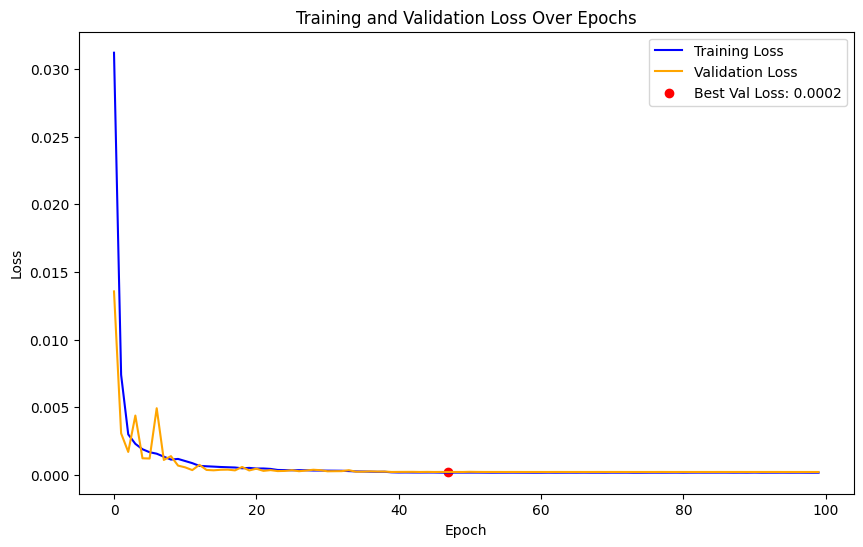

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(False)


best_epoch = np.argmin(val_losses)
plt.scatter(best_epoch, val_losses[best_epoch], color='red',
            label=f'Best Val Loss: {val_losses[best_epoch]:.4f}')
plt.legend()

plt.show()

# 3.Evaluate your model using the test images with the [software](https://github.com/YoushanZhang/Dog-Cardiomegaly_VHS)

In [ ]:
def evaluate_and_save_predictions(model, test_loader, test_images_dir, output_path='/kaggle/working/vhs_predictions.csv'):
    model.eval()
    results = []

    with torch.no_grad():
        for images, img_ids in tqdm(test_loader, desc="Generating Predictions"):
            images = images.to(device)
            outputs = model(images).cpu().numpy()

            for i, points in enumerate(outputs.reshape(-1, 6, 2)):
                img_id = img_ids[i]
                img_file = None
                for ext in ['.png', '.jpg', '.jpeg']:
                    test_path = os.path.join(test_images_dir, f"{img_id}{ext}")
                    if os.path.exists(test_path):
                        img_file = f"{img_id}{ext}"
                        break

                if not img_file:
                    continue


                points = points * 300
                try:
                    with Image.open(os.path.join(test_images_dir, img_file)) as img:
                        w, h = img.size
                        points[:, 0] = (w / 300) * points[:, 0]
                        points[:, 1] = (h / 300) * points[:, 1]
                        vhs = 6 * (np.linalg.norm(points[0]-points[1]) + np.linalg.norm(points[2]-points[3])) / np.linalg.norm(points[4]-points[5])
                        results.append([img_file, round(vhs, 4)])
                except Exception as e:
                    print(f"Skipping {img_file}: {str(e)}")
                    results.append([img_file, 0.0])

    with open(output_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(results)

    print(f"\nPredictions saved to {output_path}")


model = DogHeartLandmarkModel().to(device)

model.load_state_dict(torch.load('/kaggle/working/best_dog_model.pth',
                                map_location=device,
                                weights_only=True))

evaluate_and_save_predictions(
    model=model,
    test_loader=data_loaders['test'],
    test_images_dir=os.path.join(INPUT_PATH, 'Test_Images/Images'),
    output_path='/kaggle/working/vhs_predictions.csv'
)

Generating Predictions: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s]


Predictions saved to /kaggle/working/vhs_predictions.csv


# 4. Your results should be achieved 85%. VHS = 6(AB+CD)/EF

## (10 points, accuracy < 75% --> 0 points)

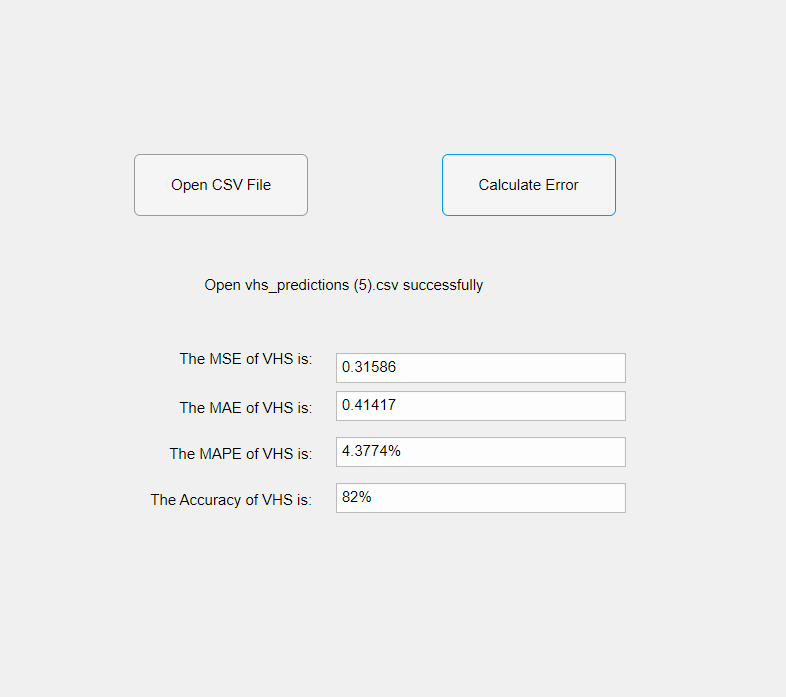

# 5. Show the comprison between predictions and ground truth
## You need to add the title with: image name, predicted VHS and Ground Truth VHS
<p align="center">
  <img src="Com.png" width="60%">
</p>


# Please show the comprison results of images: 1420.png, 1479.png and 1530.png from Valid dataset

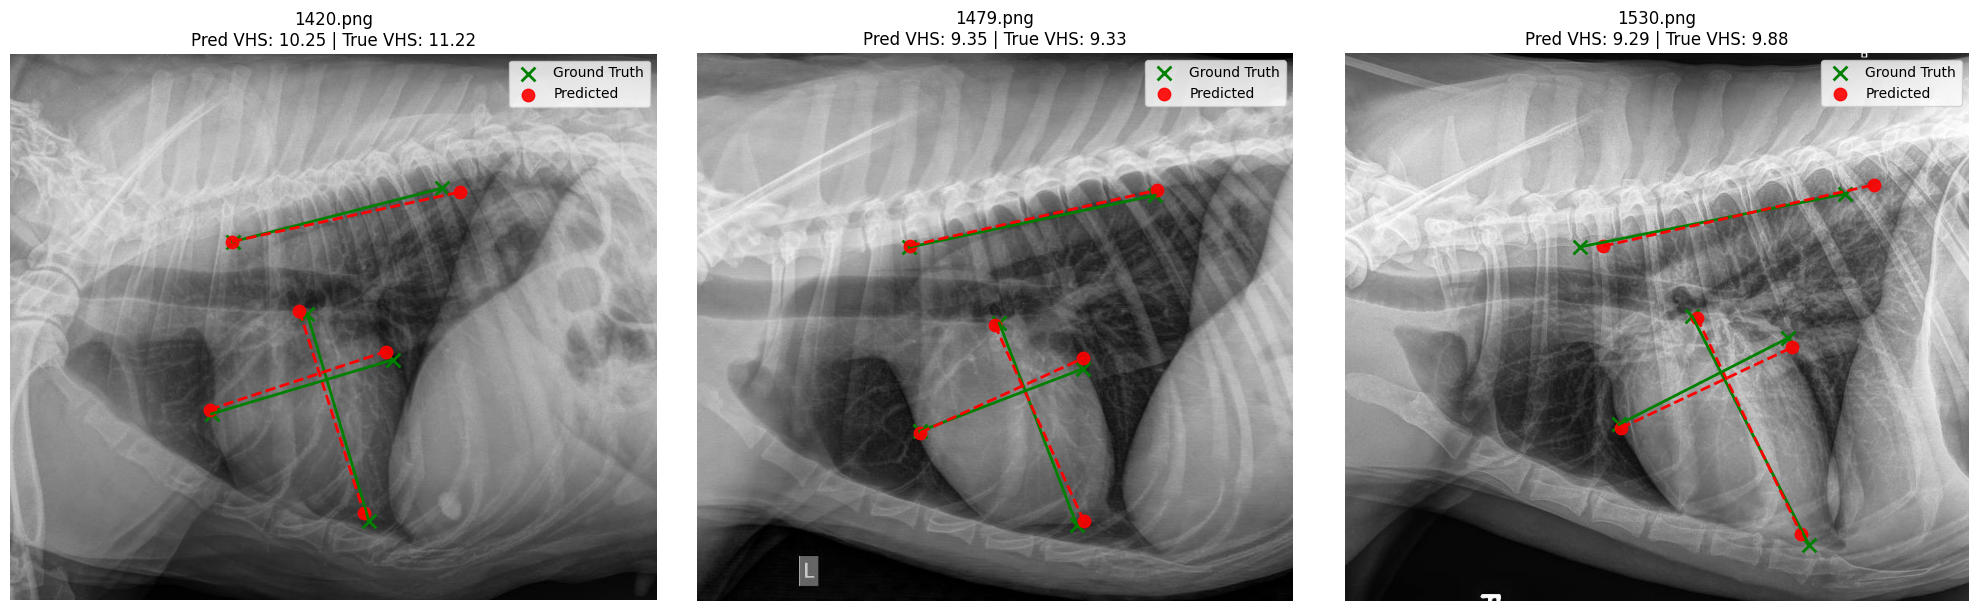

In [ ]:
def show_landmark_comparison(img_path, label_path, model, transform, device, ax):
    img = Image.open(img_path).convert("RGB")
    w, h = img.size
    img_tensor = transform(img).unsqueeze(0).to(device)

    mat = loadmat(label_path)
    gt_points = mat['six_points'].astype(float)
    gt_vhs = float(mat['VHS'].item())

    with torch.no_grad():
        pred_points = model(img_tensor).cpu().numpy().reshape(6, 2)

        pred_points *= 300
        pred_points[:, 0] = pred_points[:, 0] * (w / 300)
        pred_points[:, 1] = pred_points[:, 1] * (h / 300)

        vertical = (np.linalg.norm(pred_points[0]-pred_points[1]) +
                  np.linalg.norm(pred_points[2]-pred_points[3]))
        horizontal = np.linalg.norm(pred_points[4]-pred_points[5])
        pred_vhs = 6 * vertical / horizontal

    ax.imshow(img)

    ax.scatter(gt_points[:, 0], gt_points[:, 1],
              c='green', marker='x', s=100,
              label='Ground Truth', linewidths=2)

    ax.scatter(pred_points[:, 0], pred_points[:, 1],
              c='red', marker='o', s=80,
              label='Predicted', alpha=0.9)

    point_pairs = [(0,1), (2,3), (4,5)]
    for i, j in point_pairs:

        ax.plot([gt_points[i, 0], gt_points[j, 0]],
               [gt_points[i, 1], gt_points[j, 1]],
               'g-', linewidth=2)

        ax.plot([pred_points[i, 0], pred_points[j, 0]],
               [pred_points[i, 1], pred_points[j, 1]],
               'r--', linewidth=2)

    ax.set_title(f"{os.path.basename(img_path)}\n"
                f"Pred VHS: {pred_vhs:.2f} | True VHS: {gt_vhs:.2f}")
    ax.axis('off')
    ax.legend()

INPUT_PATH = '/kaggle/input/dog-heart-vhs/Dog_Heart_VHS'
image_names = ["1420.png", "1479.png", "1530.png"]

fig, axes = plt.subplots(1, len(image_names), figsize=(20, 6))

for ax, img_name in zip(axes, image_names):
    image_path = os.path.join(INPUT_PATH, 'Valid/Images', img_name)
    label_path = os.path.join(INPUT_PATH, 'Valid/Labels', img_name.replace(".png", ".mat"))

    show_landmark_comparison(
        img_path=image_path,
        label_path=label_path,
        model=model,
        transform=val_transform,
        device=device,
        ax=ax
    )

plt.tight_layout()
plt.show()

# 6. Write a three-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.

Research Paper Link:https://www.researchgate.net/publication/390744100_VERTEBRAL_HEART_SCALE_PREDICTION_USING_EFFICIENT_B7_MODEL

Model (path) file link:https://drive.google.com/file/d/1qOmDTfB4Tx-5lXNIavsuWyLxKRfTc-AK/view?usp=drive_link

CSV File Link: https://drive.google.com/file/d/1HqK0bOlhuFdKqdnXCCJQv3Tuh6m9p90P/view?usp=drive_link

# 7. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, prediction CSV file and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points